In [1]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [2]:
import pickle

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import cobra

from pprint import pp
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import ConstantBounds
from utils.cobra_utils import get_or_create_exchange
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes


MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"


# Load and set up model
model = read_sbml_model(MODEL_FILE)

# Set maintenance to 25 mmol/gDW/h
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Load omics data
rna_rel = pd.read_csv("../data/clean/omics/rna-rel.csv")
rna_abs = pd.read_csv("../data/clean/omics/rna-abs.csv")
prot = pd.read_csv("../data/clean/omics/prot.csv")

# Convert reaction_ids column to list
for sheet in [rna_rel, rna_abs, prot]:
    sheet["reaction_ids"] = sheet["reaction_ids"].apply(
        lambda x: x.split(", ") if isinstance(x, str) else None)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
model.genes

[<Gene G1G48-883 at 0x7f5314e11390>,
 <Gene G1G48-3028 at 0x7f5314e11240>,
 <Gene G1G48-2752 at 0x7f5314e112d0>,
 <Gene G1G48-3496 at 0x7f5314e111b0>,
 <Gene G1G48-2935 at 0x7f5314e10070>,
 <Gene G1G48-1374 at 0x7f5314e112a0>,
 <Gene G1G48-719 at 0x7f5314e11330>,
 <Gene G1G48-974 at 0x7f5314e11270>,
 <Gene G1G48-3002 at 0x7f5314e113c0>,
 <Gene G1G48-462 at 0x7f5314e113f0>,
 <Gene G1G48-116 at 0x7f5314e11420>,
 <Gene G1G48-3616 at 0x7f5314e11450>,
 <Gene G1G48-3718 at 0x7f5314e11480>,
 <Gene G1G48-2914 at 0x7f5314e114b0>,
 <Gene G1G48-934 at 0x7f5314e114e0>,
 <Gene G1G48-341 at 0x7f5314e11510>,
 <Gene G1G48-3799 at 0x7f5314e11540>,
 <Gene G1G48-14 at 0x7f5314e11570>,
 <Gene G1G48-1357 at 0x7f5314e115a0>,
 <Gene G1G48-1106 at 0x7f5314e115d0>,
 <Gene G1G48-3706 at 0x7f5314e11600>,
 <Gene G1G48-2912 at 0x7f5314e11630>,
 <Gene G1G48-2904 at 0x7f5314e11660>,
 <Gene G1G48-2902 at 0x7f5314e11690>,
 <Gene G1G48-2535 at 0x7f5314e116c0>,
 <Gene G1G48-2235 at 0x7f5314e116f0>,
 <Gene G1G48-315 at 0

In [13]:
rna_rel

Rank  gene_callers_id  DSS3_ac_mean_abund  DSS3_glc_mean_abund  \
0        1             3780            0.067258             0.003105   
1        2             3526            0.027681             0.195701   
2        3             1113            0.010721             0.000607   
3        4              368            0.071601             0.003375   
4        5              323            0.130794             0.019961   
...    ...              ...                 ...                  ...   
4337  4338             2324            0.026165             0.026287   
4338  4339             1665            0.040543             0.039794   
4339  4340             1479            0.005247             0.005091   
4340  4341             2870            0.012148             0.012356   
4341  4342             4002            0.001038             0.001042   

      DSS3_late_mean_abund  DSS3_early_mean_abund  \
0                 0.003516               0.003365   
1                 0.046760               0.025019   
2                 0.000425               0.000980   
3                 0.002749               0.037882   
4                 0.019783               0.055113   
...                    ...                    ...   
4337              0.027611               0.026666   
4338              0.038928               0.038554   
4339              0.005149               0.005138   
4340              0.012301               0.012292   
4341              0.001030               0.001040   

      DSS3_ac_v_DSS3_glc_FOLD_CHANGE_rna  DSS3_ac_v_DSS3_late_FOLD_CHANGE_rna  \
0                               4.436896                             4.258451   
1                              -2.825592                            -0.755299   
2                               4.143826                             4.659230   
3                               4.409182                             4.703722   
4                               2.715865                             2.726692   
...                                  ...                                  ...   
4337                           -0.014609                            -0.094591   
4338                            0.024609                             0.066833   
4339                            0.044644                             0.025552   
4340                           -0.024253                            -0.016251   
4341                           -0.002380                             0.017819   

      DSS3_ac_v_DSS3_early_FOLD_CHANGE_rna  \
0                                 4.322648   
1                                 0.142076   
2                                 3.456013   
3                                 0.918856   
4                                 1.247346   
...                                    ...   
4337                             -0.040659   
4338                              0.084243   
4339                              0.027654   
4340                             -0.013494   
4341                              0.001009   

      DSS3_glc_v_DSS3_late_FOLD_CHANGE_rna  ...  \
0                                -0.178445  ...   
1                                 2.070294  ...   
2                                 0.515404  ...   
3                                 0.294541  ...   
4                                 0.010827  ...   
...                                    ...  ...   
4337                             -0.079982  ...   
4338                              0.042225  ...   
4339                             -0.019093  ...   
4340                              0.008002  ...   
4341                              0.020198  ...   

      DSS3_glc_v_DSS3_early_Tukey_HSD_adjusted_p  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
...                                          ...   
4

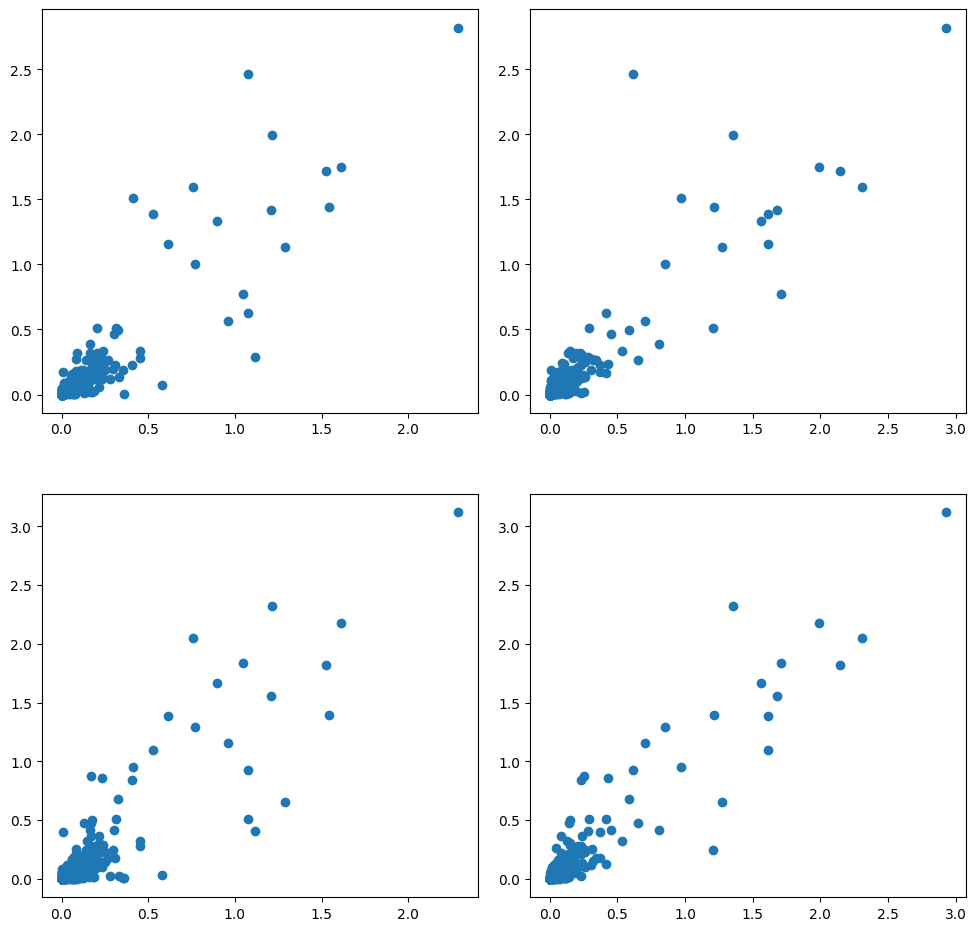

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.scatter(rna_rel["DSS3_ac_mean_abund"], rna_rel["DSS3_early_mean_abund"])
ax2.scatter(rna_rel["DSS3_glc_mean_abund"], rna_rel["DSS3_early_mean_abund"])
ax3.scatter(rna_rel["DSS3_ac_mean_abund"], rna_rel["DSS3_late_mean_abund"])
ax4.scatter(rna_rel["DSS3_glc_mean_abund"], rna_rel["DSS3_late_mean_abund"])

fig.tight_layout()
fig.set_size_inches(10, 10)

In [28]:
# Recreate plot above in plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=2)

for r, subs in enumerate(["ac", "glc"]):
    for c, timepoint in enumerate(["early", "late"]):
        fig.add_trace(
            go.Scatter(x=rna_rel[f"DSS3_{subs}_mean_abund"],
                       y=rna_rel[f"DSS3_{timepoint}_mean_abund"],
                       text=[f"{spoid} : {rxnid}, {kegg}, {function}"
                             for spoid, rxnid, kegg, function
                             in zip(rna_rel["SPO_ID (ACCESSION)"],
                                    rna_rel["reaction_ids"],
                                    rna_rel["KEGG_Module"],
                                    rna_rel["COG20_FUNCTION"])],
                       mode="markers"),
            row=r+1, col=c+1
        )

fig.show()

In [21]:
rna_rel

Rank  gene_callers_id  DSS3_ac_mean_abund  DSS3_glc_mean_abund  \
0        1             3780            0.067258             0.003105   
1        2             3526            0.027681             0.195701   
2        3             1113            0.010721             0.000607   
3        4              368            0.071601             0.003375   
4        5              323            0.130794             0.019961   
...    ...              ...                 ...                  ...   
4337  4338             2324            0.026165             0.026287   
4338  4339             1665            0.040543             0.039794   
4339  4340             1479            0.005247             0.005091   
4340  4341             2870            0.012148             0.012356   
4341  4342             4002            0.001038             0.001042   

      DSS3_late_mean_abund  DSS3_early_mean_abund  \
0                 0.003516               0.003365   
1                 0.046760               0.025019   
2                 0.000425               0.000980   
3                 0.002749               0.037882   
4                 0.019783               0.055113   
...                    ...                    ...   
4337              0.027611               0.026666   
4338              0.038928               0.038554   
4339              0.005149               0.005138   
4340              0.012301               0.012292   
4341              0.001030               0.001040   

      DSS3_ac_v_DSS3_glc_FOLD_CHANGE_rna  DSS3_ac_v_DSS3_late_FOLD_CHANGE_rna  \
0                               4.436896                             4.258451   
1                              -2.825592                            -0.755299   
2                               4.143826                             4.659230   
3                               4.409182                             4.703722   
4                               2.715865                             2.726692   
...                                  ...                                  ...   
4337                           -0.014609                            -0.094591   
4338                            0.024609                             0.066833   
4339                            0.044644                             0.025552   
4340                           -0.024253                            -0.016251   
4341                           -0.002380                             0.017819   

      DSS3_ac_v_DSS3_early_FOLD_CHANGE_rna  \
0                                 4.322648   
1                                 0.142076   
2                                 3.456013   
3                                 0.918856   
4                                 1.247346   
...                                    ...   
4337                             -0.040659   
4338                              0.084243   
4339                              0.027654   
4340                             -0.013494   
4341                              0.001009   

      DSS3_glc_v_DSS3_late_FOLD_CHANGE_rna  ...  \
0                                -0.178445  ...   
1                                 2.070294  ...   
2                                 0.515404  ...   
3                                 0.294541  ...   
4                                 0.010827  ...   
...                                    ...  ...   
4337                             -0.079982  ...   
4338                              0.042225  ...   
4339                             -0.019093  ...   
4340                              0.008002  ...   
4341                              0.020198  ...   

      DSS3_glc_v_DSS3_early_Tukey_HSD_adjusted_p  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
...                                          ...   
4

In [19]:
rna_rel["COG20_FUNCTION"]

0       ABC-type dipeptide/oligopeptide/nickel transpo...
1       Nucleotide-binding universal stress protein,  ...
2       TRAP-type C4-dicarboxylate transport system, p...
3       Methylmalonyl-CoA mutase, N-terminal domain/su...
4       NAD(P)-dependent dehydrogenase, short-chain al...
                              ...                        
4337              Protein translocase subunit YajC (YajC)
4338           Ribosome recycling factor (Frr) (PDB:1DD5)
4339    Homoaconitase/3-isopropylmalate dehydratase la...
4340              Precorrin-2 methylase (CobF) (PDB:2QBU)
4341    Acyl-CoA reductase or other NAD-dependent alde...
Name: COG20_FUNCTION, Length: 4342, dtype: object